# WGAN-GPを実装する

In [1]:
import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
import torchvision
from torchvision import datasets, transforms

path='../第12章_ニューラルネットワークの訓練をPyTorchで並列化する'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
mnist_dataset = torchvision.datasets.MNIST(
    root=path,
    train=True,
    download=False,
    transform=transform
)
example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()}, Max: {example.max()}')
print(example.shape)

Min: -1.0, Max: 1.0
torch.Size([1, 28, 28])


In [13]:
print(len(mnist_dataset))

60000


In [3]:
import numpy as np
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, 
                           bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [5]:
z_size = 100
image_size = (28, 28)
n_filters = 32 
gen_model = make_generator_network(z_size, n_filters).to(device)  
print(gen_model)
disc_model = Discriminator(n_filters).to(device)     
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [6]:
## Loss function and optimizers:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [ ]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1 
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [8]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

## Train the generator
def g_train(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()

In [9]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

epoch_samples = []

num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):    
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
 
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 4.6395/0.1087
Epoch 002 | Avg Losses >> G/D 4.9201/0.1290
Epoch 003 | Avg Losses >> G/D 3.9180/0.2521
Epoch 004 | Avg Losses >> G/D 3.1251/0.3488
Epoch 005 | Avg Losses >> G/D 2.8767/0.3560
Epoch 006 | Avg Losses >> G/D 2.8375/0.3802
Epoch 007 | Avg Losses >> G/D 2.8551/0.3590
Epoch 008 | Avg Losses >> G/D 2.7960/0.3514
Epoch 009 | Avg Losses >> G/D 2.8251/0.3516
Epoch 010 | Avg Losses >> G/D 2.8118/0.3312
Epoch 011 | Avg Losses >> G/D 2.9393/0.3049
Epoch 012 | Avg Losses >> G/D 3.0081/0.2836
Epoch 013 | Avg Losses >> G/D 3.0342/0.2897
Epoch 014 | Avg Losses >> G/D 3.1201/0.2729
Epoch 015 | Avg Losses >> G/D 3.2426/0.2467
Epoch 016 | Avg Losses >> G/D 3.2679/0.2481
Epoch 017 | Avg Losses >> G/D 3.3561/0.2338
Epoch 018 | Avg Losses >> G/D 3.3803/0.2415
Epoch 019 | Avg Losses >> G/D 3.3802/0.2480
Epoch 020 | Avg Losses >> G/D 3.4423/0.2490
Epoch 021 | Avg Losses >> G/D 3.4052/0.2270
Epoch 022 | Avg Losses >> G/D 3.4788/0.2284
Epoch 023 | Avg Losses >> G/D 3.

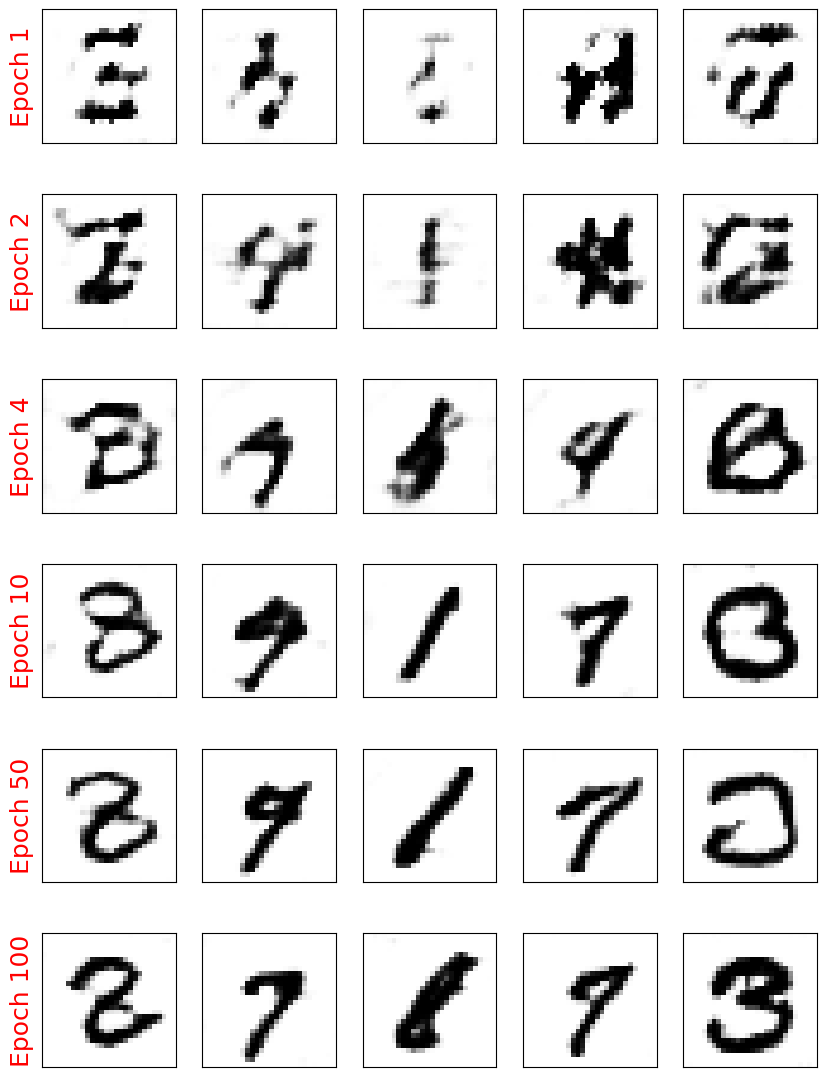

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()

In [11]:
wgan_gen_path = 'wgan_gen_model.pt'
torch.save(gen_model, wgan_gen_path)
wgan_disc_path = 'wgan_disc_model.pt'
torch.save(disc_model, wgan_disc_path)

WGAN-GP（Wasserstein GAN with Gradient Penalty）は、Wasserstein距離に基づくGANで、**勾配ペナルティ**を導入することで**1-Lipschitz制約**を安定かつ滑らかに満たすよう設計されたアルゴリズムです。
ここでは、**理論背景から数式導出、最終的なアルゴリズムまで順を追って導出**します。

---

## 🧭 ステップ0：背景と目的

* WGANは、**Wasserstein距離（Earth Mover’s distance）** をGANの損失関数として採用：

  $$
  W(P_r, P_g) = \sup_{\|f\|_L \leq 1} \mathbb{E}_{x \sim P_r}[f(x)] - \mathbb{E}_{x \sim P_g}[f(x)]
  $$

  * $f$ は **1-Lipschitz関数**：つまり、どの $x, x'$ に対しても

    $$
    |f(x) - f(x')| \leq \|x - x'\|
    $$

* 1-Lipschitz制約を実際に満たすために、元々のWGANでは**重みクリッピング**を使っていたが、これには以下の問題がある：

  * モデル表現力の制限
  * 勾配消失や爆発の原因になる

---

## 🧪 ステップ1：WGANの最適化問題

元のWGANの目的関数（Critic $f_w$ を最大化）：

$$
\max_{w \in \mathcal{W}} \mathbb{E}_{x \sim P_r}[f_w(x)] - \mathbb{E}_{x \sim P_g}[f_w(x)]
$$

ただし $f_w$ は 1-Lipschitz。

---

## ⚠ ステップ2：Lipschitz 制約の導入

**1-Lipschitz関数であること**は、数学的には以下で書ける：

$$
\|\nabla f(x)\|_2 \leq 1 \quad \text{for all } x
$$

これを満たすようにするために、\*\*期待値ベースの「ペナルティ項」\*\*を導入：

---

## 💡 ステップ3：Gradient Penaltyの導出

Gulrajani et al. (2017) は、以下のような **勾配ペナルティ付きの目的関数** を提案：

$$
\mathbb{E}_{x \sim P_g}[f_w(x)] - \mathbb{E}_{x \sim P_r}[f_w(x)] + \lambda \cdot \mathbb{E}_{\hat{x} \sim P_{\hat{x}}} \left[(\|\nabla_{\hat{x}} f_w(\hat{x})\|_2 - 1)^2\right]
$$

* $\hat{x} \sim P_{\hat{x}}$ は、**$P_r$ と $P_g$ を補間**して得たサンプル：

  $$
  \hat{x} = \epsilon x_r + (1 - \epsilon) x_g, \quad \epsilon \sim \mathcal{U}(0, 1)
  $$
* この点における勾配ノルムが1から外れた分だけ罰則を与えることで、**1-Lipschitz性をソフトに強制**している。

---

## 🧮 ステップ4：WGAN-GPの最終目的関数

### 識別器（Critic）の目的関数：

$$
L_D = - \mathbb{E}_{x \sim P_r}[D(x)] + \mathbb{E}_{\tilde{x} \sim P_g}[D(\tilde{x})] + \lambda \cdot \mathbb{E}_{\hat{x}} \left[(\|\nabla_{\hat{x}} D(\hat{x})\|_2 - 1)^2\right]
$$

### 生成器の目的関数（変わらず）：

$$
L_G = - \mathbb{E}_{\tilde{x} \sim P_g}[D(\tilde{x})]
$$

---

## 🔁 アルゴリズム（簡略版）

### 学習のステップ（1 Generator + n Critic）

1. Critic（D）を $n$ 回繰り返し更新：

   * 本物サンプル $x \sim P_r$
   * 偽物サンプル $\tilde{x} = G(z),\ z \sim P_z$
   * 補間点 $\hat{x} = \epsilon x + (1 - \epsilon)\tilde{x}$
   * 勾配ペナルティ $\left(\|\nabla_{\hat{x}} D(\hat{x})\|_2 - 1\right)^2$
   * Criticの損失 $L_D$ で最適化

2. Generator（G）を1回更新：

   * 偽物画像 $\tilde{x} = G(z)$
   * 損失 $L_G = -D(\tilde{x})$

---


## 📚 論文情報

* Gulrajani et al. (2017). ["Improved Training of Wasserstein GANs"](https://arxiv.org/abs/1704.00028)

---